# Hate Speech Detector 2.0
---
**Simple Machine Learning text classifier**

1. Load tweet min, mean and max POC scores (phrase and lda topic) for each hate-speech class. Load also other scores.
2. Implement simple ML classifiers (i.e.: DecisionTree, SVM, RandomForest, etc.).
3. Perform multilabel classification task.
4. Visualize results by 7 different hate-speech labels plus 1 overall confusion matrices.
5. Perform some test on independent sanitized tweets about polish courts.

In [1]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from src.classifiers.SimpleMLClassifier import SimpleMLClassifier
from src.dataframes.utils import combine_row_wisely, shuffle_dataframe
from src.visualization.classification import confusion_matrices, models_quality_plot, best_model_for_class
from src.constants import (LABELS, LABELS_SMALL, SCORE_TYPES,
                           HATEFUL_EXT_DIR, VULGARS_EXT_DIR,
                           DUPLICATED_PATH, POC_SCORES_PATH, TOPIC_POC_SCORES_PATH, OTHER_SCORES_PATH,
                           TAGGER_MODEL, POLISH_STOPWORDS)

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
plt.style.use('ggplot')

## Data loading

### Classes

In [4]:
df_classes = pd.read_csv(DUPLICATED_PATH)[LABELS]
df_classes.head(2)

,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0


### Tweet POC scores for each class

In [5]:
df_poc_scores = pd.read_csv(POC_SCORES_PATH).drop(['id'], axis=1)
df_poc_scores.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,pon_POC_max,styg_POC_min,styg_POC_mean,styg_POC_max,szan_POC_min,szan_POC_mean,szan_POC_max,vulg_POC_min,vulg_POC_mean,vulg_POC_max
0,0.000000,0.000000,0.0,-0.5,-0.002193,0.5,0.0,0.000000,0.000000,0.0,...,0.5,-0.5,0.000260,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.333333,0.004526,0.5,-0.5,0.000808,0.5,0.0,0.006219,0.333333,-0.5,...,0.5,-0.5,-0.004606,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet topic POC for each class

In [6]:
df_topic_poc_scores = pd.read_csv(TOPIC_POC_SCORES_PATH).drop(['id'], axis=1)
df_topic_poc_scores.head(2)

,wyz_topic_POC_min,wyz_topic_POC_mean,wyz_topic_POC_max,groz_topic_POC_min,groz_topic_POC_mean,groz_topic_POC_max,wyk_topic_POC_min,wyk_topic_POC_mean,wyk_topic_POC_max,odcz_topic_POC_min,...,pon_topic_POC_max,styg_topic_POC_min,styg_topic_POC_mean,styg_topic_POC_max,szan_topic_POC_min,szan_topic_POC_mean,szan_topic_POC_max,vulg_topic_POC_min,vulg_topic_POC_mean,vulg_topic_POC_max
0,0.0,0.000000,0.000000,-0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,...,0.052632,-0.052632,0.002632,0.052632,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.005263,0.052632,-0.052632,-0.010526,0.000000,-0.052632,-0.002632,0.052632,-0.052632,...,0.000000,-0.052632,-0.010526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0


### Tweet other scores

In [7]:
df_other_scores = pd.read_csv(OTHER_SCORES_PATH).drop(['id'], axis=1)
df_other_scores.head(2)

,s_neg,s_neu,s_pos,n_chars,n_sylls,n_words,nu_words,nl_chars,nl_sylls,nl_words,nlu_words
0,0,6,1,36,15,7,7,35,13,7,7
1,1,18,1,94,38,18,18,88,33,16,16


### Combined data

In [8]:
df_data = combine_row_wisely([df_poc_scores, df_topic_poc_scores, df_other_scores, df_classes])
df_data = shuffle_dataframe(df_data)
df_data.head(2)

,wyz_POC_min,wyz_POC_mean,wyz_POC_max,groz_POC_min,groz_POC_mean,groz_POC_max,wyk_POC_min,wyk_POC_mean,wyk_POC_max,odcz_POC_min,...,nl_sylls,nl_words,nlu_words,wyzywanie,grożenie,wykluczanie,odczłowieczanie,poniżanie,stygmatyzacja,szantaż
9775,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,35,20,18,0,0,0,0,0,0,0
15468,0.0,0.0,0.0,-1.0,0.000115,0.333333,0.0,0.0,0.0,0.0,...,41,22,22,0,0,0,0,0,0,0


## Models implementation and testing

In [9]:
MODEL_CLASSES = [DecisionTreeClassifier, DecisionTreeClassifier,
                 RandomForestClassifier, RandomForestClassifier,
                 SGDClassifier, SGDClassifier,
                 LogisticRegression, LogisticRegression,
                 ]
MODEL_KWARGS = [{'criterion': 'gini', 'class_weight': 'balanced'},
                {'criterion': 'entropy', 'class_weight': 'balanced'},
                {'criterion': 'gini', 'class_weight': 'balanced'},
                {'criterion': 'entropy', 'class_weight': 'balanced'},
                {'penalty': 'l1', 'class_weight': 'balanced'},
                {'penalty': 'l2', 'class_weight': 'balanced'},
                {'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced'},
                {'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced'},
                ]
MODEL_LABELS = ['DTC-gini', 'DTC-entropy',
                'RFC-gini', 'RFC-entropy',
                'SGD-l1', 'SGD-l2',
                'LRC-l1', 'LRC-l2',
                ]

In [10]:
X_data = df_data.drop(LABELS, axis=1).values
y_data = df_data[LABELS].values

y_preds = list([])

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


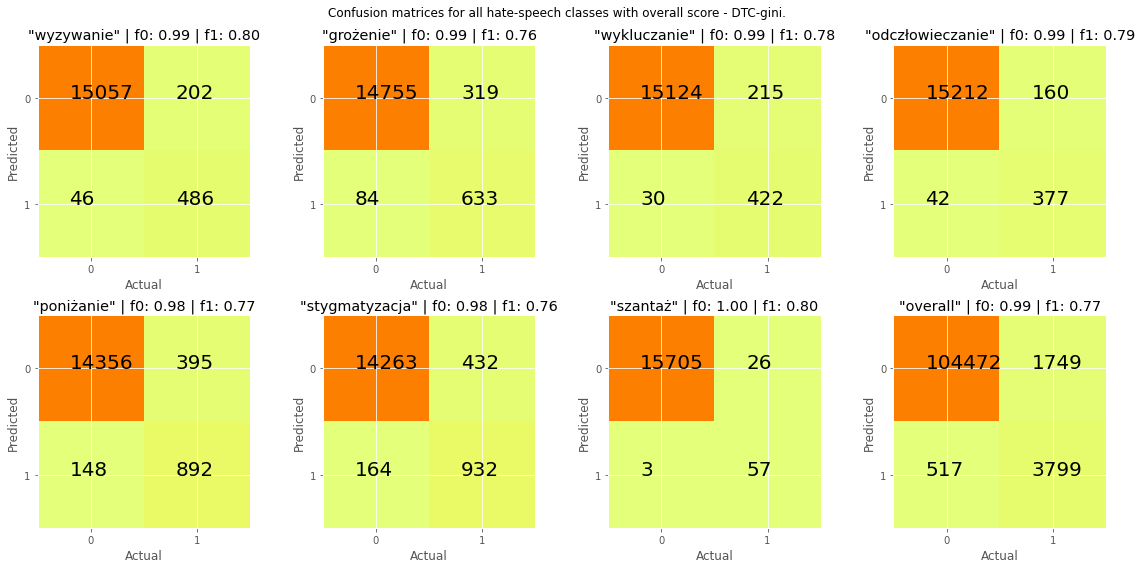

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


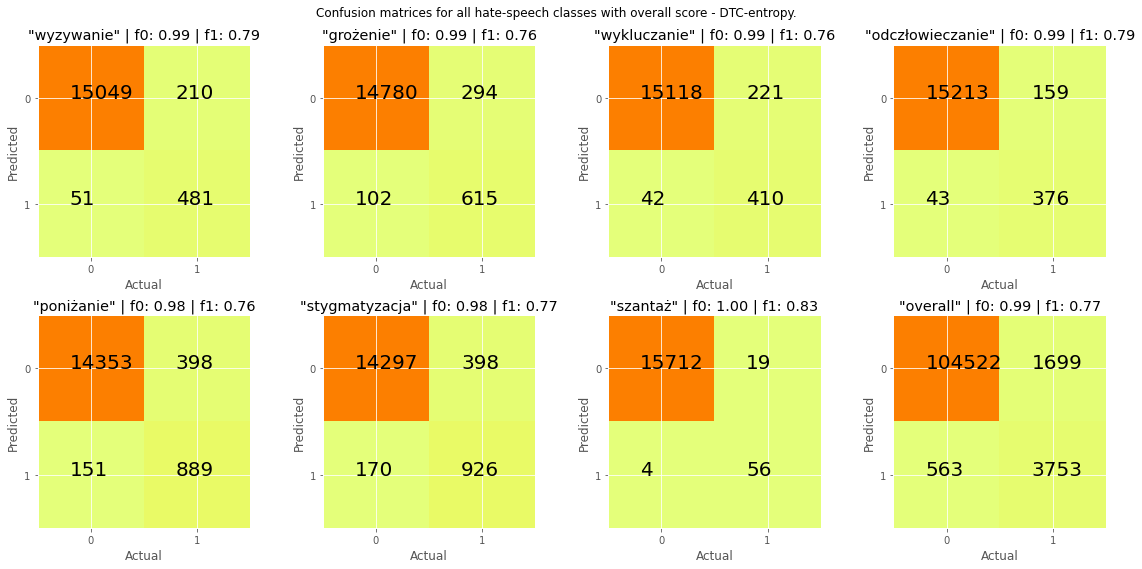

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


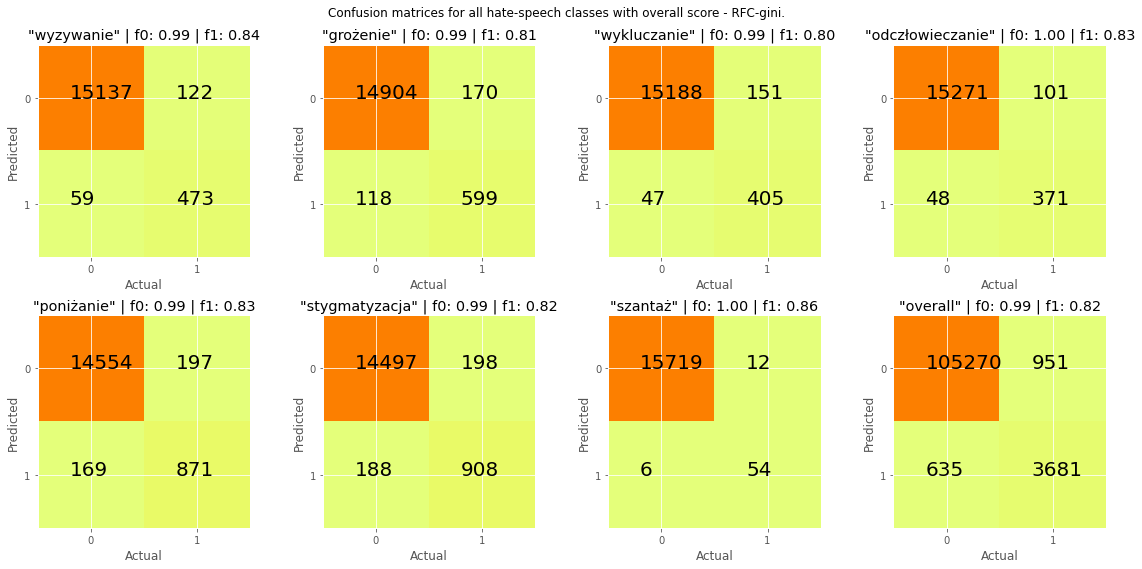

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


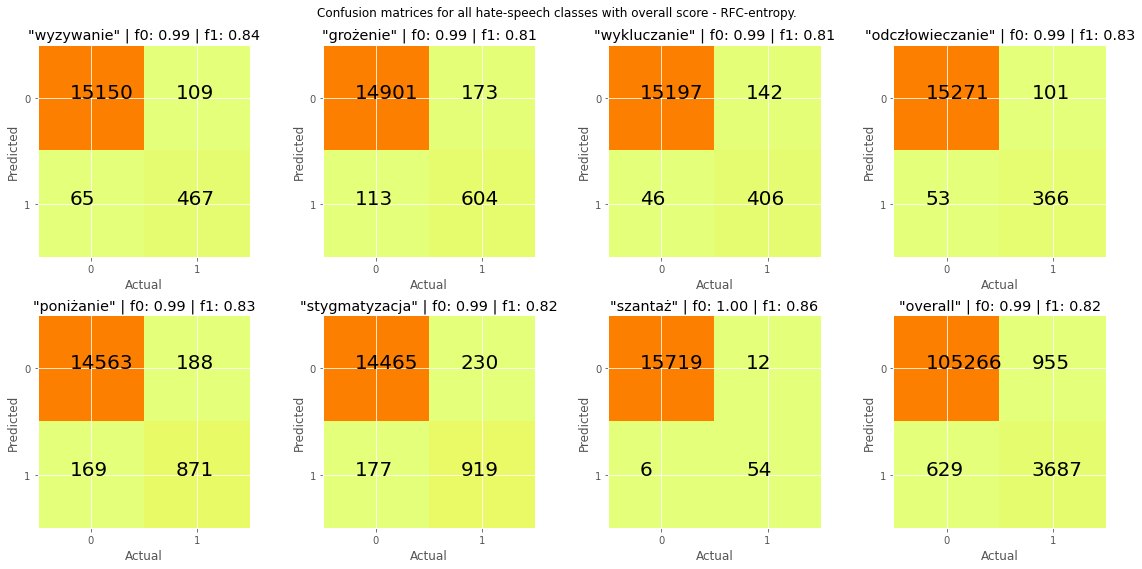

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


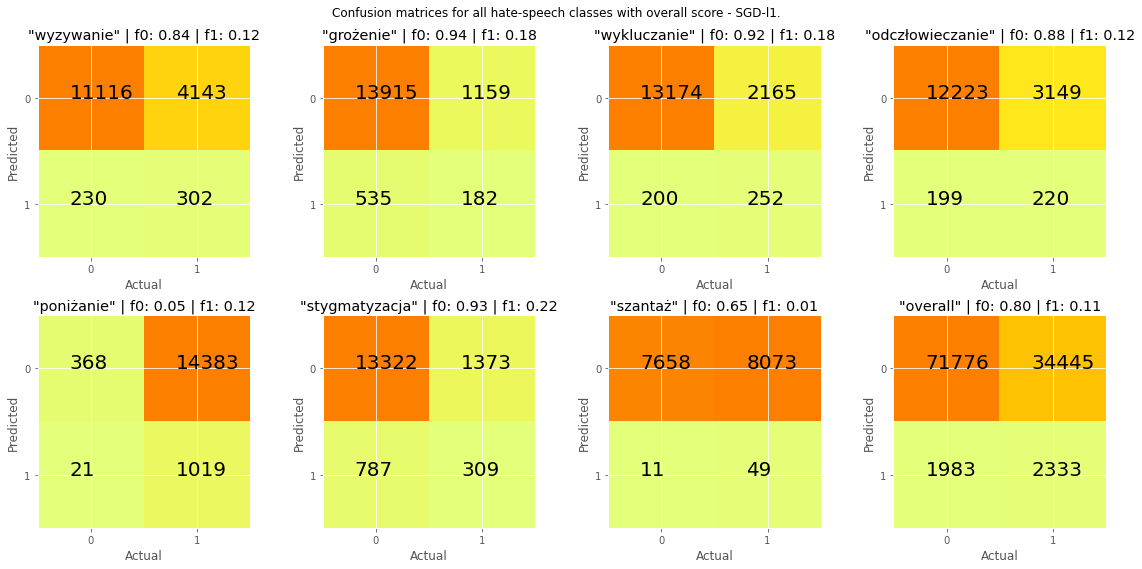

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


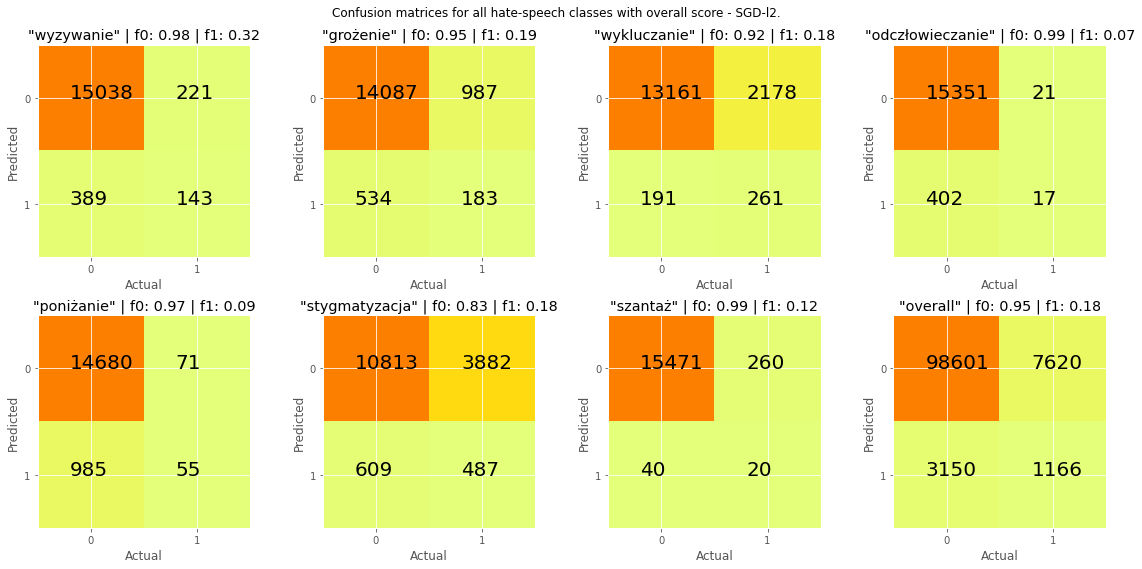

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


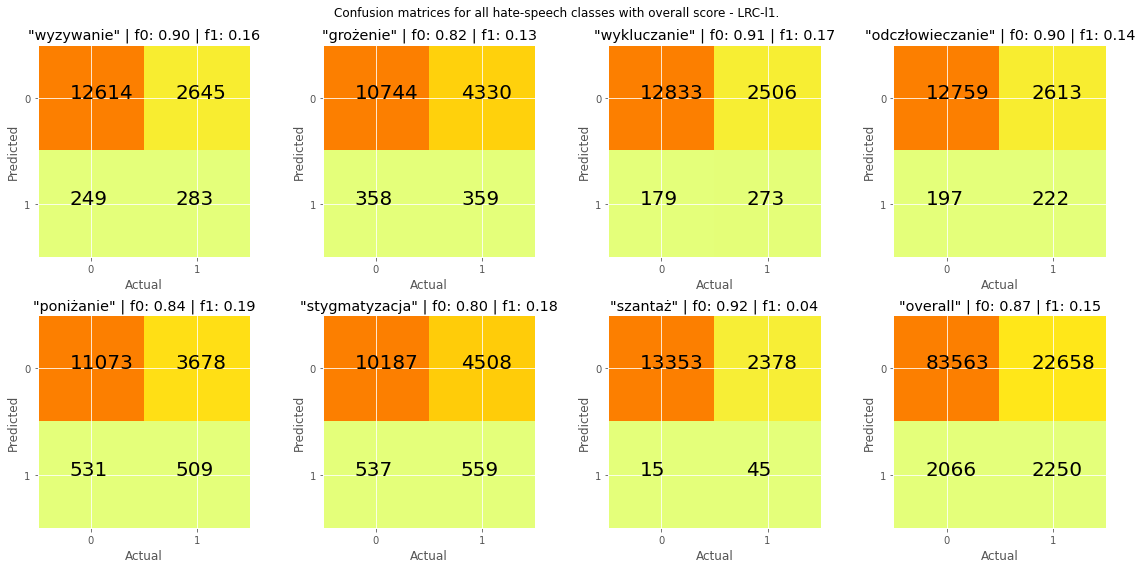

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


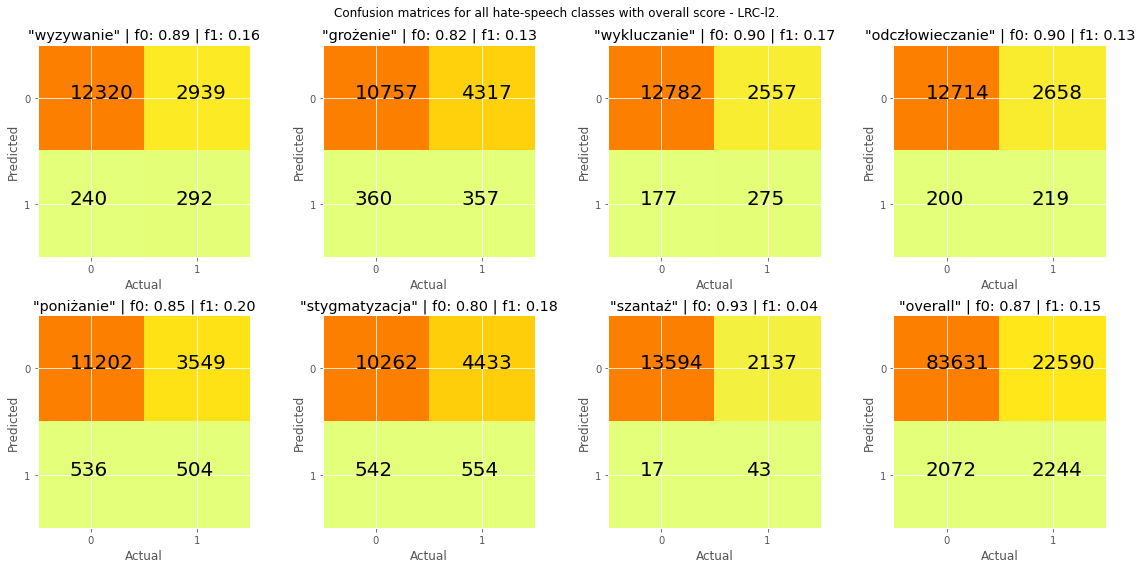

In [11]:
for mclass, mkwargs, mlabel in tqdm(zip(MODEL_CLASSES, MODEL_KWARGS, MODEL_LABELS),
                                                   total=len(MODEL_LABELS), leave=None):
    clf = SimpleMLClassifier(k_folds=5, short_name=mlabel, clf_class=mclass, verbose=0, **mkwargs)
    
    clf.fit(X_data, y_data)
    # clf.load()
    clf.save()
    
    y_pred = clf.predict(X_data)
    confusion_matrices(y_data, y_pred,
                       title=f'Confusion matrices for all hate-speech classes with overall score - {mlabel}.')
    y_preds.append(y_pred)
y_preds = np.array(y_preds)

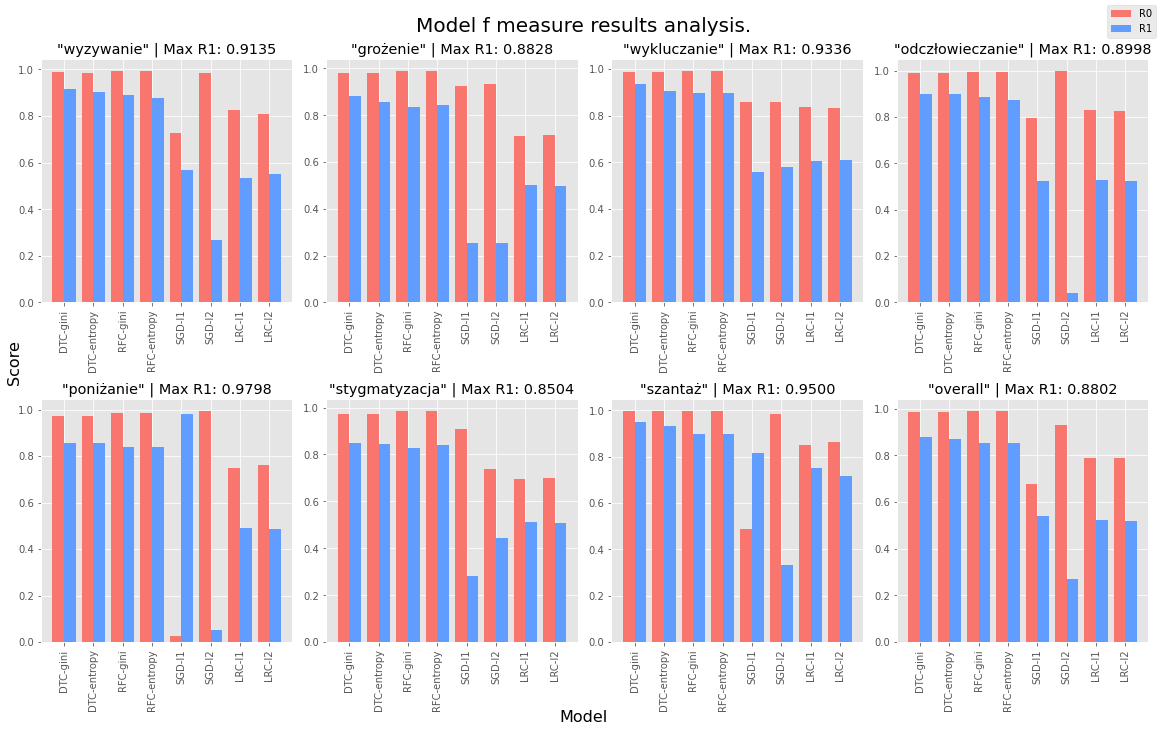

In [12]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model f measure results analysis.', measure='r', colors=['#f9766e', '#619dff'])

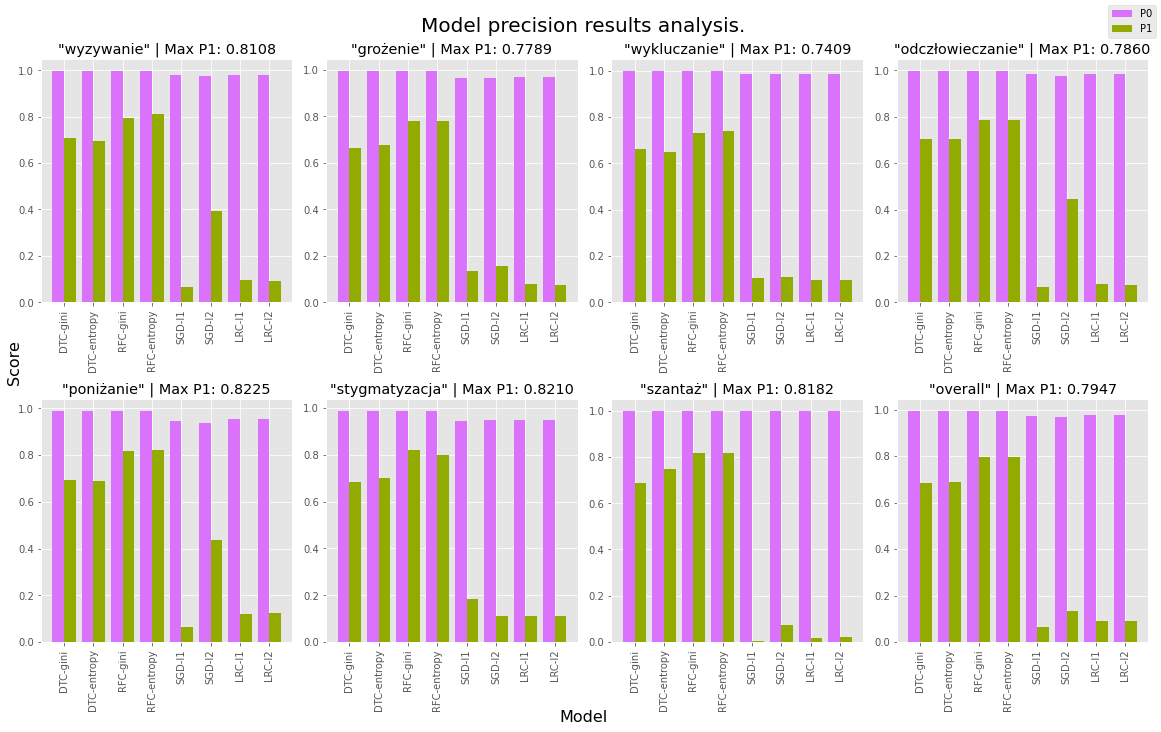

In [13]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model precision results analysis.', measure='p', colors=['#da72fb', '#93aa00'])

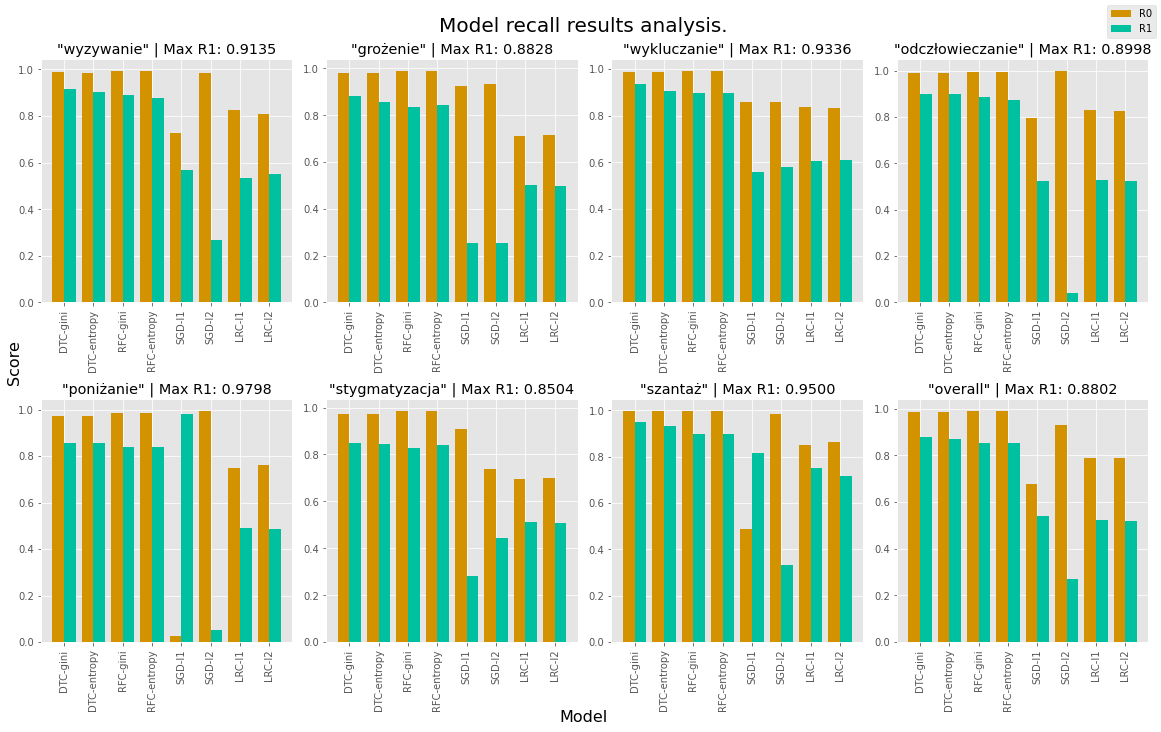

In [14]:
models_quality_plot(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS,
                    title='Model recall results analysis.', measure='r', colors=['#d39200', '#00c19f'])

## Best classifier

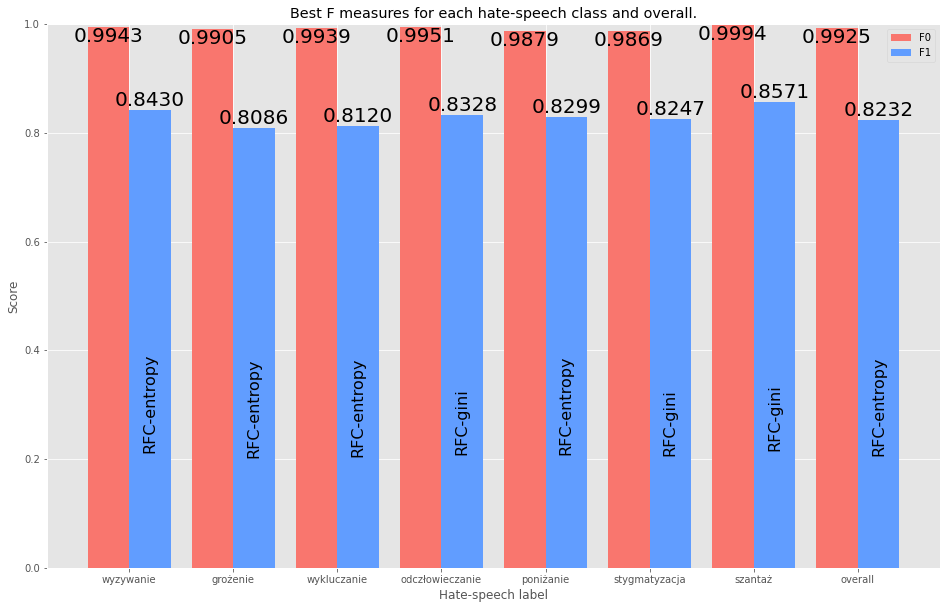

In [15]:
best_model_for_class(y_trues=y_data, y_preds_s=y_preds, model_names=MODEL_LABELS)

Judging by the above analyses the best simple ML classifier is **RandomForest with gini loss**.

In [16]:
clf = SimpleMLClassifier(k_folds=5, short_name='RFC-entropy', clf_class=RandomForestClassifier,
                         **{'criterion': 'entropy', 'class_weight': 'balanced'})
clf.load()

/home/jakub/Dokumenty/Semestr 9.2/HSD2/src/utils/ext.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(aphr)


## Tests

### Test 1

In [17]:
test_text1 = 'nie. po prostu skorumpowane zgniłe zatrute przez ciebie i twoich kolesiów sądy, które swoich zawsze wybronią'
preds1 = clf.test(test_text1)
dict(zip(LABELS, preds1.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'stygmatyzacja': 1.0.

### Test 2

In [18]:
test_text2 = 'To nie sądy, to ludzie, sędziowie, zdrajcy barbarzyńcy w togach z mafijnej organizacji zdradziecko zbrodniczej którzy muszą zostać wyeliminowani'
preds2 = clf.test(test_text2)
dict(zip(LABELS, preds2.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be 'grożenie', 'wykluczanie', 'poniżanie' and 'stygmatyzacja' as 1.0.

### Test 3

In [19]:
test_text3 = 'Przed repolonizacją teren wyczyścić! Raz, dwa! Nie patrzeć na boki! Sądy sądami, ale media muszą być nasze media '
preds3 = clf.test(test_text3)
dict(zip(LABELS, preds3.flatten()))

{'wyzywanie': 0,
 'grożenie': 0,
 'wykluczanie': 0,
 'odczłowieczanie': 0,
 'poniżanie': 0,
 'stygmatyzacja': 0,
 'szantaż': 0}

Empirically should be: 'grożenie': 1.0.